# RAG with a Tool Use approach

<a target="_blank" href="https://colab.research.google.com/github/wandb/edu/blob/main/rag-advanced/notebooks/rag_tooluse/rag_tooluse_v1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<!--- @wandbcode{rag-course-05-cohere} -->



Tool use allows for greater flexibility in accessing and utilizing data sources, thus unlocking new use cases not possible with a standard RAG approach.

In an enterprise setting where data sources are diverse with non-homogeneous formats (structured/semi-structured/unstructured), this approach becomes even more important.

In this notebook, we'll look at how we can implement an agentic RAG system using a tool use approach. We'll do this by building a Weights & Biases assistant. The assistant can search for information about how to use the product, retrieve information from the internet, search code examples, and even perform data analysis.

Concretely, we'll cover the following use cases:
1. Tool routing
2. Parallel tool use
3. Multi-step tool use
4. Self-correction
5. Structured queries
6. Structured data queries
7. Action (plotting charts)

We'll give the assistant access to the following tools:
- `search_developer_docs`: Searches the Weights & Biases developer documentation
- `search_internet`: Searches the internet for general queries
- `search_code_examples`: Searches code examples and tutorials on using Weights & Biases
- `analyze_evaluation_results`: Analyzes a table containing results from evaluating an LLM application

Note that for simplicity, we are not implementing a full-fledge search. Instead, we'll use a mock datasets containing small, pre-defined data for each tool.

# Setup

In [2]:
import cohere
co = cohere.Client("COHERE_API_KEY") # Get your free API key: https://dashboard.cohere.com/api-keys"

from tool_def_v1 import (
    search_developer_docs,
    search_internet,
    search_code_examples,
    analyze_evaluation_results,
    search_tools,
    analysis_tool
)

In [3]:
functions_map = {
    "search_developer_docs": search_developer_docs,
    "search_internet": search_internet,
    "search_code_examples": search_code_examples,
    "analyze_evaluation_results": analyze_evaluation_results
}

In [4]:
preamble="""## Task and Context
You are an assistant who helps developers use Weights & Biases. The company is also referred to as Wandb or W&B for short. You are equipped with a number of tools that can provide different types of information. If you can't find the information you need from one tool, you should try other tools if there is a possibility that they could provide the information you need. Use the internet to search for information not available in the sources provided by Weights & Biases"""

# Function to run the agent

In [5]:
model = "command-r-plus-08-2024"

def run_agent(message, tools, chat_history=None):
    
    if chat_history is None:
        chat_history = []

    # Step 1: Get user message
    print(f"Question:\n{message}")
    print("="*50)

    # Step 2: Generate tool calls (if any)    
    response = co.chat(
        message=message,
        model=model,
        preamble=preamble,
        tools= tools,
        chat_history=chat_history,
        temperature=0.1
    )

    while response.tool_calls:
        tool_calls = response.tool_calls
        
        if response.text:
            print("Tool plan:")
            print(response.text,"\n")
        print("Tool calls:")
        for call in tool_calls:            
            ###############
            if call.name == "analyze_evaluation_results":
                print(f"Tool name: {call.name}")
                print(f"Code:\n")
                tool_call_prettified = print("\n".join(f"  {line}" for line_num, line in enumerate(call.parameters["code"].splitlines())))
                print(tool_call_prettified)
            else:
                print(f"Tool name: {call.name} | Parameters: {call.parameters}")
            ###############
            
        print("="*50)
        
        # Step 3: Get tool results
        tool_results = []
        for tc in tool_calls:
            tool_call = {"name": tc.name, "parameters": tc.parameters}
            tool_output = functions_map[tc.name](**tc.parameters)
            tool_results.append({"call": tool_call, "outputs": [tool_output]})
        
        # Step 4: Generate response and citations                
        response = co.chat(
            message="",
            model=model,
            preamble=preamble,
            tools=tools,
            tool_results=tool_results,
            chat_history=response.chat_history,
            temperature=0.1
        )

        # Append the current chat turn to the chat history
        chat_history = response.chat_history
        
    # Print final response
    print("Final response:")
    print(response.text)
    print("="*50)
    
    # Print citations (if any)
    show_documents = False # set this to True to see the documents used for the response
    if response.citations:
        print("Citations:")
        for citation in response.citations:
            print(citation)
        if show_documents:
            print("\nCited Documents:")
            for document in response.documents:
                print(document)
        print("="*50)
    
    return chat_history

# 1: Tool routing

With tool routing, the agent decides which tool(s) to use based on the user's query.

In [6]:
messages = run_agent("Where can I find the output of a run", search_tools)
# chooses search_developer_docs

Question:
Where can I find the output of a run
Tool plan:
I will search for 'where to find output of a run' in the developer documentation. 

Tool calls:
Tool name: search_developer_docs | Parameters: {'query': 'where to find output of a run'}
Final response:
To view a run, navigate to the W&B App UI, select the relevant project, and then choose the run from the 'Runs' table.
Citations:
start=15 end=118 text="navigate to the W&B App UI, select the relevant project, and then choose the run from the 'Runs' table." document_ids=['search_developer_docs:0:2:0']


In [20]:
messages = run_agent("Who are the co authors of the sentence transformer paper?", search_tools)
# chooses search_internet

Question:
Who are the co authors of the sentence transformer paper?
Tool plan:
I will search for the sentence transformer paper. 

Tool calls:
Tool name: search_internet | Parameters: {'query': 'sentence transformer paper'}
Tool plan:
I found a paper called 'Sentence Embeddings using Siamese BERT-Networks'. I will now search for the co-authors of this paper. 

Tool calls:
Tool name: search_internet | Parameters: {'query': 'co-authors of Sentence Embeddings using Siamese BERT-Networks'}
Final response:
The co-authors of the paper 'Sentence Embeddings using Siamese BERT-Networks' are Nils Reimers and Iryna Gurevych.
Citations:
start=28 end=77 text="'Sentence Embeddings using Siamese BERT-Networks'" document_ids=['search_internet:0:2:0']
start=82 end=86 text='Nils' document_ids=['search_internet:0:2:0']
start=87 end=94 text='Reimers' document_ids=['search_internet:0:2:0', 'search_internet:0:4:0']
start=99 end=104 text='Iryna' document_ids=['search_internet:0:4:0']
start=105 end=114 text='

# 2: Parallel tool use

The agent can call multiple tools in parallel. In this example, given that the user is asking about two different things in a single message, the agent generates two parallel tool calls.

In [38]:
messages = run_agent("Explain what is a W&B Run and how do I view a specific run", search_tools)

Question:
Explain what is a W&B Run and how do I view a specific run
Tool plan:
I will search for 'W&B Run' and 'view a specific run' in the developer documentation. 

Tool calls:
Tool name: search_developer_docs | Parameters: {'query': 'W&B Run'}
Tool name: search_developer_docs | Parameters: {'query': 'view a specific run'}
Final response:
A W&B Run is a single unit of computation logged by W&B, representing an atomic element of your project.

To view a specific run, navigate to the W&B App UI, select the relevant project, and then choose the run from the 'Runs' table.
Citations:
start=15 end=104 text='single unit of computation logged by W&B, representing an atomic element of your project.' document_ids=['search_developer_docs:0:2:0', 'search_developer_docs:1:2:0']
start=130 end=233 text="navigate to the W&B App UI, select the relevant project, and then choose the run from the 'Runs' table." document_ids=['search_developer_docs:0:2:0', 'search_developer_docs:1:2:0']


# 3: Multi-step tool use

There will be scenarios where tool calling needs to happen in a sequence. For example, when the output of one tool call is needed as input for another tool call.

In this example, the agent first searches the developer docs for information about how to view a run. Then, it uses the information to search for a code example.

In [41]:
chat_history = run_agent("What's that feature to automate hyperparameter search? Do you have some code tutorials?", search_tools)
# Does two steps of tool use in a sequence
# Returns code examples

Question:
What's that feature to automate hyperparameter search? Do you have some code tutorials?
Tool plan:
I will search for the feature to automate hyperparameter search. Then, I will search for code tutorials for this feature. 

Tool calls:
Tool name: search_developer_docs | Parameters: {'query': 'feature to automate hyperparameter search'}
Tool plan:
I have found that the feature to automate hyperparameter search is called W&B Sweeps. I will now search for code tutorials for W&B Sweeps. 

Tool calls:
Tool name: search_code_examples | Parameters: {'file_type': None, 'language': None, 'query': 'W&B Sweeps'}
Final response:
The feature to automate hyperparameter search is called W&B Sweeps. You can use W&B Sweeps to automate hyperparameter search and visualise rich, interactive experiment tracking.

Here are some code tutorials for W&B Sweeps:
- Selecting Hyperparameters with Sweeps (Keras)
- Create a hyperparameter search with W&B PyTorch integration
Citations:
start=56 end=67 text=

# 4: Self-correction

The concept of multi-step tool use can be extended to self-correction. Given the output of the current tool call, the agent may decide to change its plan i.e. self-correct. 

In this example, the agent doesn't find the information it's looking for in the developer docs. Thus, it generates a new tool call to search the internet.

In [44]:
messages = run_agent("What is Wandb's weave solution?", search_tools)

Question:
What is Wandb's weave solution?
Tool plan:
I will search for 'Wandb's weave solution' to find the answer. 

Tool calls:
Tool name: search_developer_docs | Parameters: {'query': "Wandb's weave solution"}
Tool plan:
I could not find any information about Wandb's weave solution. I will now search the internet for 'Wandb's weave solution' to find the answer. 

Tool calls:
Tool name: search_internet | Parameters: {'query': "Wandb's weave solution"}
Final response:
Weights & Biases Weave is a lightweight toolkit for software developers who want to deploy generative AI applications with confidence. It provides software developers with a system of record for the experimental large language model (LLM).

Weave automatically captures all input and output data and builds a tree to help you understand how data flows through your application. It is designed with the developer experience in mind, providing capabilities for straightforward evaluation and debugging of GenAI applications.
Cit

# 5: Structured queries

The tool use setup can be leveraged to perform structured queries. For data sources that contain rich metadata, structured queries can be used to perform highly-specific queries, returning more accurate results.

In this example, we can take advantage of metadata available in the code examples dataset such as the file type and language.

In [45]:
messages = run_agent("Any jupyter notebook for Data Versioning with Artifacts?", search_tools)
# Tool call: Searches search_code_examples with file_type = ipynb
# Answer: Returns file - Model/Data Versioning with Artifacts (PyTorch)

Question:
Any jupyter notebook for Data Versioning with Artifacts?
Tool plan:
I will search for a Jupyter notebook for Data Versioning with Artifacts. 

Tool calls:
Tool name: search_code_examples | Parameters: {'file_type': 'ipynb', 'language': 'en', 'query': 'Data Versioning with Artifacts'}
Final response:
Yes, there is a Jupyter notebook for Data Versioning with Artifacts (PyTorch).
Citations:
start=16 end=77 text='Jupyter notebook for Data Versioning with Artifacts (PyTorch)' document_ids=['search_code_examples:0:2:0']


# 6: Structured data queries

The agent can generate queries against structured data sources, such as a CSV file or a database.

In this example, we'll use a mock dataset containing LLM application evaluation results for different use cases and settings. Since it's a CSV file, we can create the `analyze_evaluation_results` tool to perform queries on the dataset using the pandas library, executed by a Python interpreter.

In [22]:
messages = run_agent("What's the average evaluation score in run A", analysis_tool)
# Answer: 0.63

Question:
What's the average evaluation score in run A
Tool plan:
I will use the 'analyze_evaluation_results' tool to find the average evaluation score in run A. 

Tool calls:
Tool name: analyze_evaluation_results
Code:

  import pandas as pd
  
  df = pd.read_csv("evaluation_results.csv")
  
  # Filter the dataframe to only include rows where the 'run' column is 'A'
  filtered_df = df[df['run'] == 'A']
  
  # Calculate the average 'score' for the filtered dataframe
  average_score = filtered_df['score'].mean()
  
  print(f"Average score in run A: {average_score}")
None
Final response:
The average evaluation score in run A is **0.63**.
Citations:
start=43 end=47 text='0.63' document_ids=['analyze_evaluation_results:0:2:0']


In [25]:
messages = run_agent("What's the latency of the highest-scoring run for the summarize_article use case?", analysis_tool)
# Answer: 4.8

Question:
What's the latency of the highest-scoring run for the summarize_article use case?
Tool plan:
I will use the analyze_evaluation_results tool to find the latency of the highest-scoring run for the summarize_article use case. 

Tool calls:
Tool name: analyze_evaluation_results
Code:

  import pandas as pd
  
  df = pd.read_csv("evaluation_results.csv")
  
  # Filter for the summarize_article use case
  filtered_df = df[df["usecase"] == "summarize_article"]
  
  # Find the highest-scoring run
  highest_score_run = filtered_df.loc[filtered_df["score"].idxmax()]
  
  # Print the latency of the highest-scoring run
  print(f"The latency of the highest-scoring run for the summarize_article use case is {highest_score_run['latency']} seconds.")
None
Final response:
The latency of the highest-scoring run for the summarize_article use case is 4.8 seconds.
Citations:
start=77 end=89 text='4.8 seconds.' document_ids=['analyze_evaluation_results:0:2:0']


In [26]:
messages = run_agent("Which use case uses the least amount of tokens on average and what's the average token count?", analysis_tool)
# Answer: extract_names (106.25)

Question:
Which use case uses the least amount of tokens on average and what's the average token count?
Tool plan:
I will use the 'analyze_evaluation_results' tool to find the use case that uses the least amount of tokens on average and the average token count. 

Tool calls:
Tool name: analyze_evaluation_results
Code:

  import pandas as pd
  
  df = pd.read_csv("evaluation_results.csv")
  
  # Calculate the average number of tokens for each use case
  average_tokens_per_usecase = df.groupby("usecase")["tokens"].mean()
  
  # Find the use case with the lowest average token count
  min_tokens_usecase = average_tokens_per_usecase.idxmin()
  min_tokens_count = average_tokens_per_usecase.min()
  
  print(f"Use case with the lowest average token count: {min_tokens_usecase}")
  print(f"Average token count for this use case: {min_tokens_count}")
None
Final response:
The use case with the lowest average token count is `extract_names`, with an average token count of 106.25.
Citations:
start=52 

# 7. Action (plotting charts)

Since we have access to the Python interpreter, we can also use it to perform other tasks such as plotting charts.

Question:
Show a chart of the average evaluation score for each temperature setting for the extract_names use case.
Tool plan:
I will write Python code to generate a chart of the average evaluation score for each temperature setting for the extract_names use case. 

Tool calls:
Tool name: analyze_evaluation_results
Code:

  import pandas as pd
  
  df = pd.read_csv("evaluation_results.csv")
  
  # Filter the dataframe to only include rows for the extract_names use case
  filtered_df = df[df["usecase"] == "extract_names"]
  
  # Group the dataframe by temperature and calculate the average score
  average_scores = filtered_df.groupby("temperature")["score"].mean()
  
  # Plot the average scores
  ax = average_scores.plot(kind="bar")
  ax.set_xlabel("Temperature")
  ax.set_ylabel("Average Score")
  
  # Rotate x-axis labels for better readability
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  
  # Save the plot as a PNG file
  ax.figure.savefig("average_scores.png")

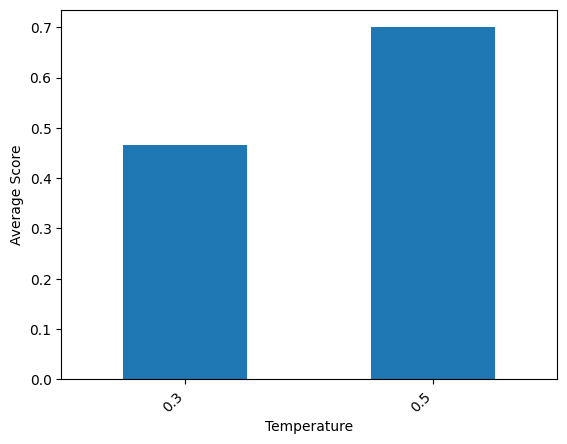

In [34]:
messages = run_agent("Show a chart of the average evaluation score for each temperature setting for the extract_names use case.", analysis_tool)
# Answer: temp 0.3 (0.46 avg score) vs temp 0.5 (0.7 avg score). And draws a plot

# Conclusion

This notebook demonstrates how we can implement an agentic RAG system with tool use.

We covered the following use cases:
1. Tool routing
2. Parallel tool use
3. Multi-step tool use
4. Self-correction
5. Structured queries
6. Structured data queries
7. Action (plotting charts)